In [11]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
# Train a VAE (on MNIST dataset) for the tasks of generating MNIST-like digits.

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return h[:, :self.latent_dim], h[:, self.latent_dim:]
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + std*eps
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss_function(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, self.input_dim), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD
    
    def sample(self, n):
        z = torch.randn(n, self.latent_dim)
        return self.decode(z)
    
    def reconstruct(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z)
    
    def generate(self, n):
        z = torch.randn(n, self.latent_dim)
        return self.decode(z)
    
    def interpolate(self, x1, x2, n):
        mu1, logvar1 = self.encode(x1.view(-1, self.input_dim))
        mu2, logvar2 = self.encode(x2.view(-1, self.input_dim))
        z1 = self.reparameterize(mu1, logvar1)
        z2 = self.reparameterize(mu2, logvar2)
        z = torch.zeros(n, self.latent_dim)
        for i in range(n):
            z[i] = z1 + (z2 - z1) * i / (n - 1)
        return self.decode(z)
    

# Define the training function
def trainvae(model, train_loader, optimizer, epoch, log_interval):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0 and batch_idx != 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx*len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)
            ))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)
    ))


# Define the testing function
def testvae(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            recon_batch, mu, logvar = model(data)
            test_loss += model.loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))



In [13]:

# training parameters on MNIST dataset
batch_size = 128
epochs = 10
lr = 1e-3
log_interval = 100

# load the MNIST dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

# initialize the VAE model with encoder learning on a 16 dimensional latent space
model = VAE(784, 400, 16)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)

# train the VAE model
for epoch in range(1, epochs + 1):
    trainvae(model, train_loader, optimizer, epoch, log_interval)
    testvae(model, test_loader)

# save the trained model
torch.save(model.state_dict(), 'vae.pth')

# load the trained model
model.load_state_dict(torch.load('vae.pth'))


Train Epoch: 1 [12800/60000 (21%)]	Loss: 185.401962
Train Epoch: 1 [25600/60000 (43%)]	Loss: 147.082535
Train Epoch: 1 [38400/60000 (64%)]	Loss: 141.503922
Train Epoch: 1 [51200/60000 (85%)]	Loss: 130.270691
====> Epoch: 1 Average loss: 162.9627
====> Test set loss: 126.7511
Train Epoch: 2 [12800/60000 (21%)]	Loss: 120.994415
Train Epoch: 2 [25600/60000 (43%)]	Loss: 121.826866
Train Epoch: 2 [38400/60000 (64%)]	Loss: 118.801819
Train Epoch: 2 [51200/60000 (85%)]	Loss: 118.553955
====> Epoch: 2 Average loss: 121.3176
====> Test set loss: 115.8021
Train Epoch: 3 [12800/60000 (21%)]	Loss: 115.794266
Train Epoch: 3 [25600/60000 (43%)]	Loss: 118.276321
Train Epoch: 3 [38400/60000 (64%)]	Loss: 114.759537
Train Epoch: 3 [51200/60000 (85%)]	Loss: 111.945000
====> Epoch: 3 Average loss: 114.9963
====> Test set loss: 112.2297
Train Epoch: 4 [12800/60000 (21%)]	Loss: 109.955360
Train Epoch: 4 [25600/60000 (43%)]	Loss: 113.538307
Train Epoch: 4 [38400/60000 (64%)]	Loss: 110.469231
Train Epoch: 4 [

<All keys matched successfully>

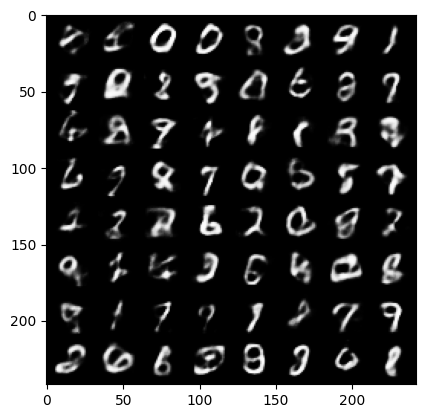

In [14]:
# generate 64 samples from the trained model and display them in a single figure
with torch.no_grad():
    sample = model.sample(64)
    sample = sample.view(64, 1, 28, 28)
    vutils.save_image(sample, 'sample.png')


plt.imshow(plt.imread('sample.png'))